In [170]:
import numpy as np
import matplotlib.pyplot as plt

In [171]:
def plot_system(part_pos, part_vel, t_index, i, pist_height,pist_vel):
    '''This method plots the particles and the piston at a timestep,with their velocity represented by arrows
    and highlighting the particle that hit the boundary at the timestep with red
    
    Inputs
    
    part_pos: position array of particles
    part_vel: velocity array of particles
    t_index: the index of the min dt in the dt array
    i:
    pist_height: the height of the piston at the timestep
    pist_vel: the velocity of the piston at the timestep
    
    Outputs
    
    '''
    # Plot the positions
    text = np.zeros(N,dtype="object")
    plt.rcParams['figure.figsize'] = [4, 4*1.2] 
    plt.plot(part_pos[:,0],part_pos[:,1],"o")
    plt.plot(part_pos[t_index[0],0], part_pos[t_index[0],1],"o",color='red')
    plt.plot((0,box_width),(pist_height, pist_height)) 
    plt.title("before "+str(i)+" th hit")
    plt.xlabel("width")
    plt.ylabel("height")
    plt.xlim(0,box_width)
    plt.ylim(0,12)
    
    # Plot part No and velocity 
    for i in range(N):
        plt.text(part_pos[i,0]+0.2, part_pos[i,1], i)
    plt.quiver(part_pos[:,0],part_pos[:,1],part_vel[:,0],part_vel[:,1])
    plt.quiver(box_width/2,pist_height,0,pist_vel)
    plt.show()

In [172]:
def calc_hit_time(part_pos, part_vel, pist_height, pist_vel):
    '''This function calculates the time for each particle until it hits a boundary using 
    using the position of the particles, the piston and the veloctiy of the particles and the piston
    
    Inputs:
    part_pos: position array of particles 
    part_vel: velocity array of particles
    pist_height the height of the particle
    pist_vel: the velocity of the particle
    
    Output:
    min_t: the minimum value of the time for each particle to hit a boundary
    t_index: the index of dtmin in the array of hit times
    is_pist: True or False if the particle with the smalles hit times hits the piston or not
    
    '''
    # story 4 values for each particle, the time until it hits all four boundaries
    # if the particle doesn't have a velocity in the boundary's direction set the time to 
    # a large integer
    hit_time = np.zeros((N,4))   
    min_t = 0
    part_no = 0
    is_pist = False
    # MAX_INT represents the hit time when the particle would never hit that wall
    for i in range(N):      
        # going to +X
        if(part_vel[i,0]>0):
            hit_time[i,0] = (box_width-part_pos[i,0])/abs(part_vel[i,0])
            hit_time[i,1] = MAX_INT      
        # going to -X
        else:
            hit_time[i,1] = part_pos[i,0]/abs(part_vel[i,0])
            hit_time[i,0] = MAX_INT
            
        # hit with the bottom
        if part_vel[i,1]<0:
            hit_time[i,3] = part_pos[i,1]/abs(part_vel[i,1])
        else:
            hit_time[i,3] = MAX_INT
        
        # hit with the piston
        t = (-(pist_vel-part_vel[i,1])-np.sqrt((pist_vel-part_vel[i,1])**2-4*g/2*(pist_height-part_pos[i,1])))/g
        hit_time[i,2]=t
    
    # Index of the particle to which dtmin belongs
    t_index = np.unravel_index(np.argmin(hit_time, axis=None), hit_time.shape)
    # The valie of dtmin
    min_t = hit_time[t_index]
    if(t_index[1]==2):
        is_pist = True
    
    return min_t, t_index, is_pist

1e-05
1.0
5.0
10.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
Wall time: 1h 15min 58s


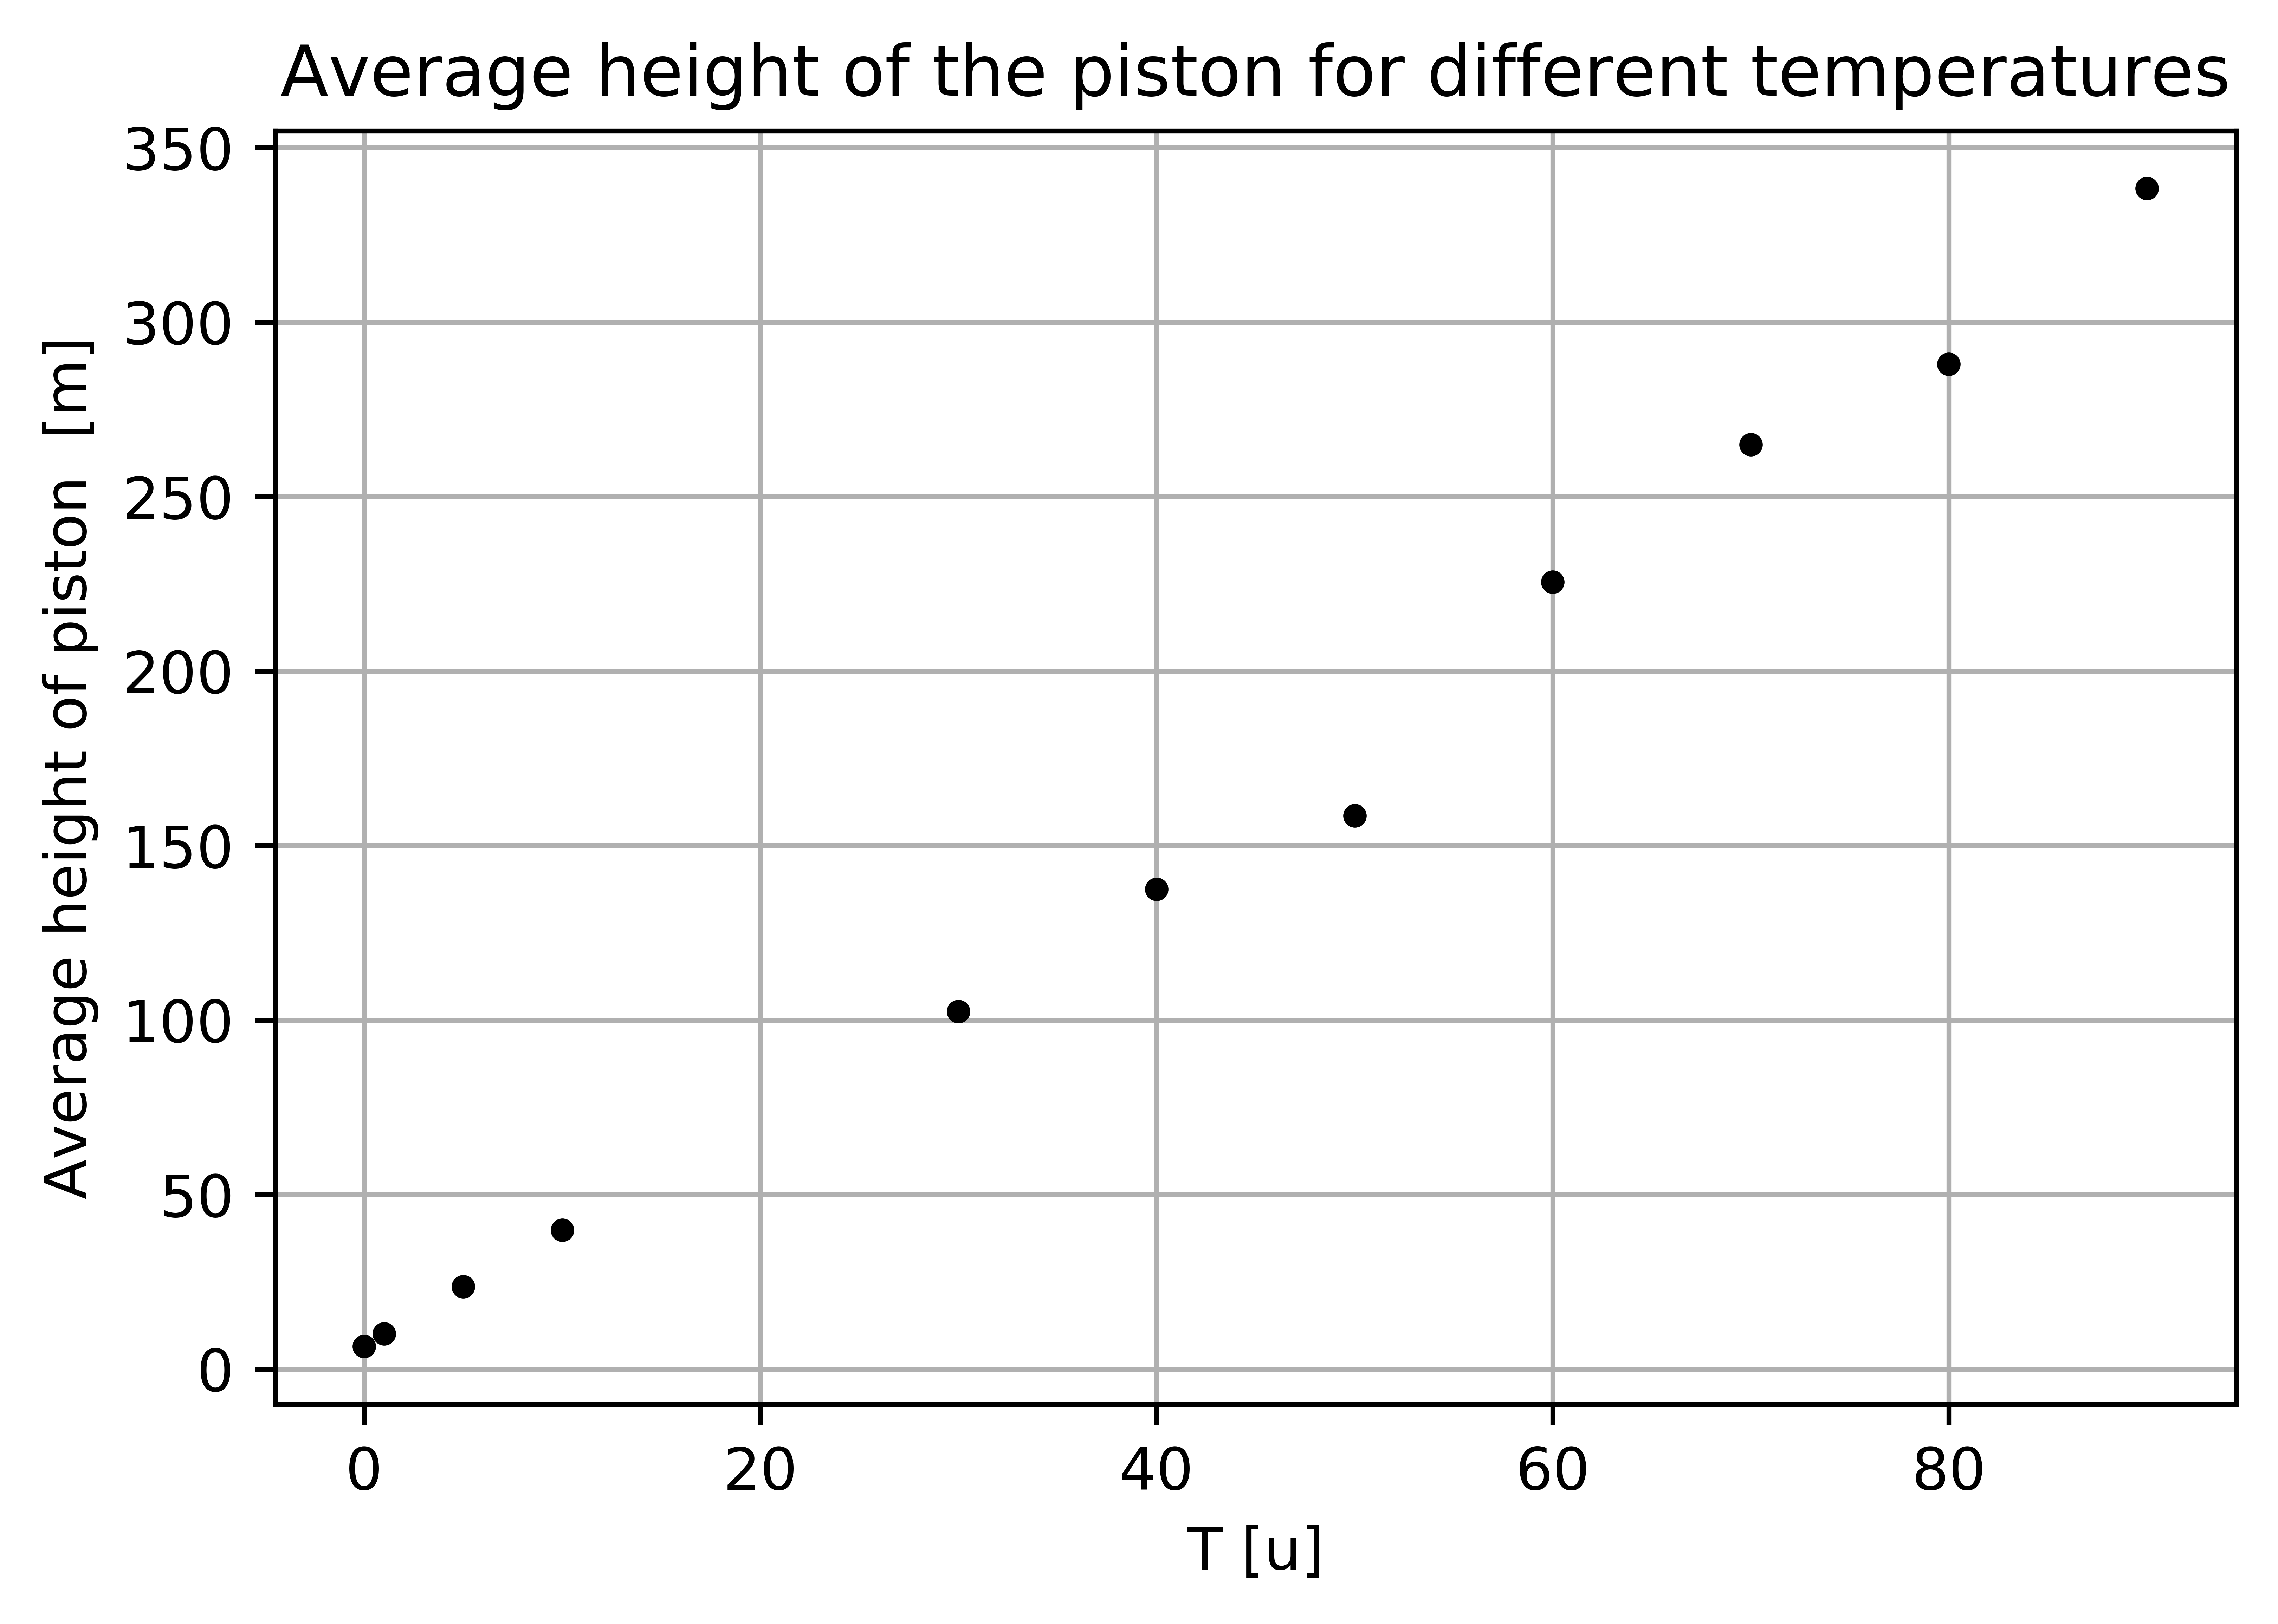

In [236]:
%%time
# Run the simulation for different temperatures for Nsteps=75000
Temp = np.array([1e-5,1,5,10,30,40,50,60,70,80,90])
avg_h = np.zeros(int(Temp.size))
plt.figure(dpi=1200)
for i in range(Temp.size):

    # Parameters
    kB = 1 
    g = -9.81 # m/s^2
    T = Temp[i] # K
    m_part = 0.1  # kg
    m_pist = 10 # kg
    N = 1000 # number of particles
    box_width = 10  # m
    MAX_INT = 9999999
    max_y = 10 # maximum height where the particles can be initialised

    # Store values for one timestep
    pist_height = 10  # m
    pist_vel = 0 
    part_pos = np.random.rand(N,2) # m
    part_vel = np.random.rand(N,2) # m/s

    mu = 0
    sigma = np.sqrt(kB*T/m_part)

    # Initialize positions and velocities for particles

    # Velocity using the velocity distribution
    part_vel[:,0] = np.random.normal(mu,sigma, N)
    part_vel[:,1] = np.random.normal(mu,sigma, N)
    # Position
    part_pos[:,0] = part_pos[:,0]*box_width
    part_pos[:,1] = part_pos[:,1]*max_y

    # Number of timesteps
    No=75000

    # Arrays to save data every timestep
    pist_v= np.zeros((No+1,2))
    pist_h = np.zeros(No+1)
    part_v = np.zeros((No+1,N,2))
    t = np.zeros(No+1)
    pist_h[0] = pist_height
    part_v[0] = part_vel

    for j in range(No):

        # Calculate hit times
        min_t, t_index, isPist = calc_hit_time(part_pos, part_vel, pist_height, pist_vel)
     
        # Plot system before collision   
        #if(j%3000==0):
            #plot_system(part_pos, part_vel, t_index, j, pist_height,pist_vel)
    
        # Recalculate positions and pist vel after min time
        part_pos = part_pos+part_vel*min_t
        pist_height = pist_height + pist_vel*min_t + g/2*min_t**2
        pist_vel = pist_vel+g*min_t

        # Recalculate velocity, check if the hit is with the piston or the other walls
        if(isPist):
            temp = part_vel[t_index[0],1]
            part_vel[t_index[0],1]=(m_part-m_pist)/(m_part+m_pist)*temp+2*m_pist/(m_part+m_pist)*pist_vel
            # Place particle bit under the piston so its not left behind
            part_pos[t_index[0],1]=pist_height-0.01
            pist_vel=2*m_part/(m_part+m_pist)*temp+(m_pist-m_part)/(m_pist+m_part)*pist_vel
        else:
            if (t_index[1]==0 or t_index[1]==1):
                part_vel[t_index[0],0] = -part_vel[t_index[0],0]
            else:
                part_vel[t_index[0],1] = -part_vel[t_index[0],1]
        # Save data for plotting
        pist_h[j+1] = pist_height
        pist_v[j+1] = pist_vel
        part_v[j+1] = part_vel
        t[j+1]=t[j]+min_t
    #title = str(i)+"th_run.txt"
    #np.savetxt(title, pist_h, delimiter=',') 
    print(T)
    plt.plot(T,np.mean(pist_h),'.',color="000000")
    #plt.legend(loc='upper right')
    plt.ylabel('Average height of piston  [m]')
    plt.xlabel('T [u]')
    #plt.ylim(0,26)
    #plt.xlim(0,50)
    plt.title("Average height of the piston for different temperatures")
plt.grid()
plt.savefig("pic1.png")